# Goal

* tSNE plot of incorporator niche for each OTU
  * plotting each OTU based on which substrates/days each isotope was incorporated
* looking into ways of defining functional guilds by binning the OTUs based on their incorporator status

# Setting variables

In [1]:
import os
%load_ext rpy2.ipython
%load_ext pushnote

In [2]:
%%R
workDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/l2fc_heavy_window/tSNE/'
figDir = '/home/nick/notebook/fullCyc/figures/incorporators/tSNE/'

# physeq
physeqDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/phyloseq/'
physeqSIP = 'SIP-core_unk_spar0.25'

# log2 fold change
l2fcResDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/l2fc_heavy_window/'
l2fcResFile = file.path(l2fcResDir, 'l2fc_sparse-maxRejH.txt')

# tree files
treeFile = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/fasttree/otusn_pick.tree'

# params
padj.cutoff = 0.05   # adjusted p-value cutoff for selecting incorporators
nprocs = 24

# Init

In [3]:
%Rpull workDir
workDir = workDir[0]
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
%cd $workDir    

/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/l2fc_heavy_window/tSNE


In [4]:
%%R
library(phyloseq)
library(dplyr)
library(tidyr)
library(ggplot2)
library(tsne)
library(kohonen)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Find out what's changed in ggplot2 at
http://github.com/hadley/ggplot2/releases.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: 

# Loading files

In [86]:
%%R 
# log2 fold change analysis results file
df.l2fc = read.delim(l2fcResFile, sep='\t') %>%
    mutate(Rank2 = gsub('^__', '', Rank2),
           Rank3 = gsub('^__', '', Rank3),
           Rank4 = gsub('^__', '', Rank4),
           Rank5 = gsub('^__', '', Rank5),
           Rank6 = gsub('^__', '', Rank6),
           Rank7 = gsub('^__', '', Rank7))
df.l2fc %>% head(n=3)

  Substrate Day Microcosm_replicate sparsity_threshold      OTU log2FoldChange
1   13C-Ami   1                   2               0.25  OTU.514    -0.67802374
2   13C-Ami   1                   2               0.25  OTU.816    -0.06751225
3   13C-Ami   1                   2               0.25 OTU.1099    -0.01965210
          p padj    Rank1          Rank2               Rank3
1 0.9999869    1 Bacteria Proteobacteria Deltaproteobacteria
2 0.9839460    1 Bacteria Proteobacteria Deltaproteobacteria
3 0.9867221    1 Bacteria  Acidobacteria               32-21
                 Rank4          Rank5      Rank6                Rank7 Rank8
1    Desulfobacterales Nitrospinaceae uncultured uncultured_bacterium  <NA>
2    Desulfobacterales Nitrospinaceae uncultured uncultured_bacterium  <NA>
3 uncultured_bacterium           <NA>       <NA>                 <NA>  <NA>


# Selecting incorporators

In [87]:
%%R

df.inc = df.l2fc %>%
    filter(padj < padj.cutoff)

cat('Total number of incorporator OTUs:', df.inc$OTU %>% unique %>% length, '\n')

Total number of incorporator OTUs: 418 


In [88]:
%%R
df.l2fc = df.l2fc %>% 
    mutate(Incorporator = (padj < padj.cutoff) %>% as.numeric) 
df.l2fc %>% head(n=3)

  Substrate Day Microcosm_replicate sparsity_threshold      OTU log2FoldChange
1   13C-Ami   1                   2               0.25  OTU.514    -0.67802374
2   13C-Ami   1                   2               0.25  OTU.816    -0.06751225
3   13C-Ami   1                   2               0.25 OTU.1099    -0.01965210
          p padj    Rank1          Rank2               Rank3
1 0.9999869    1 Bacteria Proteobacteria Deltaproteobacteria
2 0.9839460    1 Bacteria Proteobacteria Deltaproteobacteria
3 0.9867221    1 Bacteria  Acidobacteria               32-21
                 Rank4          Rank5      Rank6                Rank7 Rank8
1    Desulfobacterales Nitrospinaceae uncultured uncultured_bacterium  <NA>
2    Desulfobacterales Nitrospinaceae uncultured uncultured_bacterium  <NA>
3 uncultured_bacterium           <NA>       <NA>                 <NA>  <NA>
  Incorporator
1            0
2            0
3            0


## Using l2fc matrix for tSNE

In [89]:
%%R 
# selecting all incorporator OTUs, keeping l2fc values for all substrates/days

cat('Total number of incorporator OTUs:', df.inc$OTU %>% unique %>% length, '\n')

df.l2fc.w = df.l2fc %>%
    filter(OTU %in% df.inc$OTU) %>%
    unite(Substrate_Day, Substrate, Day, sep='_') %>%
    dplyr::select(OTU, Substrate_Day, log2FoldChange) %>%
    spread(Substrate_Day, log2FoldChange, fill=0) 
rownames(df.l2fc.w) = df.l2fc.w$OTU
df.l2fc.w$OTU = NULL

df.l2fc.w %>% nrow %>% print
df.l2fc.w %>% head(n=3)

Total number of incorporator OTUs: 418 
[1] 418
            13C-Ami_1 13C-Ami_14  13C-Ami_3  13C-Ami_6  13C-Cel_14  13C-Cel_3
OTU.1     -0.01820865  0.1739515 -0.3314178 -0.6235129 -0.54059364 -0.2302009
OTU.10019  0.61441986 -0.2550232  0.2052660 -0.9731104  3.90597961  0.8263626
OTU.1002   0.00000000 -1.0709669  0.0000000  0.0000000  0.03407083  0.0000000
          13C-Cel_30 13C-Cel_48  13C-Cel_6 13C-Glu_1 13C-Glu_14 13C-Glu_3
OTU.1      0.1457742  0.3395559 -0.4822453 1.2098681  0.5253327 0.2585179
OTU.10019  1.6166713 -0.1469741  0.5798252 0.1360641 -1.0149975 0.0000000
OTU.1002   2.8229272 -0.2068126  0.0000000 0.0000000 -1.3953232 0.0000000
            13C-Glu_6 13C-Gly_1 13C-Gly_14  13C-Gly_3  13C-Gly_6 13C-Lac_1
OTU.1     -0.01600647 0.8641228  0.4527054 -0.8361779 -0.4264192 0.9301583
OTU.10019 -0.95787122 0.4955757  1.1851210  1.0199176 -0.1613348 0.1663213
OTU.1002   0.00000000 0.0000000  0.2485669  0.0000000  0.0000000 0.0000000
           13C-Lac_3  13C-Lac_6   13C-Oxa_14

In [21]:
%%R
tsne.res = tsne(df.l2fc.w)
saveRDS(tsne.res, 'tsne_l2fc')

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #100 error is: 17.7276154666036

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #200 error is: 1.20001931505706

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #300 error is: 1.16493590945273

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #400 error is: 1.23907149093031

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #500 error is: 1.22994961038134

  res = super(Function, self).__call__(*new_args, **new_kwa

In [90]:
%%R
# formatting tSNE output
df.tsne.res = readRDS('tsne_l2fc') %>% as.data.frame
colnames(df.tsne.res) = c('tsne_axis1', 'tsne_axis2')
#df.tsne.res = as.data.frame(tsne.res)
df.tsne.res$OTU = rownames(df.l2fc.w)
df.tsne.res %>% head

  tsne_axis1  tsne_axis2       OTU
1 -37.851244 -60.9563854     OTU.1
2 -46.323791  39.3962494 OTU.10019
3  -9.134854   0.2250353  OTU.1002
4  38.887773  46.9495799  OTU.1004
5  45.913210  -5.3148620  OTU.1008
6 -13.497896  55.9518677  OTU.1016


### Adding clusters based on t-SNE distribution

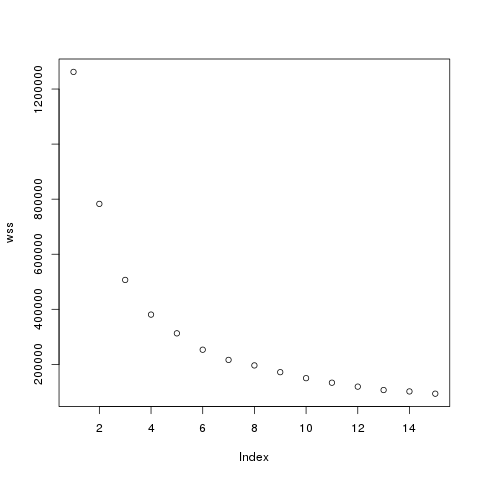

In [91]:
%%R
# kmeans
mydata = tsne.res 
wss = (nrow(mydata)-1)*sum(apply(mydata,2,var)) 
for (i in 2:15) {
  wss[i] = sum(kmeans(mydata, centers=i)$withinss)
}
plot(wss)

In [92]:
%%R
## use hierarchical clustering to cluster the codebook vectors
n.clusts = 6
df.tsne.res$tsne_cluster = cutree(hclust(dist(tsne.res)), n.clusts) %>% as.vector 
df.tsne.res = df.tsne.res %>%
    mutate(tsne_cluster = tsne_cluster %>% as.character)
df.tsne.res %>% head

  tsne_axis1  tsne_axis2       OTU tsne_cluster
1 -37.851244 -60.9563854     OTU.1            1
2 -46.323791  39.3962494 OTU.10019            2
3  -9.134854   0.2250353  OTU.1002            3
4  38.887773  46.9495799  OTU.1004            4
5  45.913210  -5.3148620  OTU.1008            4
6 -13.497896  55.9518677  OTU.1016            5


### Appending tsne values to metadata

In [93]:
%%R
# incorporator of a particular substrate
df.l2fc.nSub = df.l2fc %>% 
    filter(OTU %in% df.inc$OTU) %>%
    group_by(OTU, Substrate) %>%
    summarize(Incorp_for_sub = any(Incorporator) %>% as.numeric) %>%
    summarize(Incorp_nSubs = sum(Incorp_for_sub)) 

df.l2fc.nSub = inner_join(df.l2fc.nSub, df.l2fc, c('OTU' = 'OTU')) %>%
    distinct(OTU) %>%
    dplyr::select(-Substrate, -Day, -log2FoldChange, -p, -padj, -Incorporator)


df.l2fc.nSub = inner_join(df.l2fc.nSub, df.tsne.res, c('OTU' = 'OTU'))

df.l2fc.nSub %>% nrow %>% print
df.l2fc.nSub %>% head(n=3) %>% as.data.frame

[1] 418
        OTU Incorp_nSubs Microcosm_replicate sparsity_threshold    Rank1
1     OTU.1            1                   2               0.25 Bacteria
2 OTU.10019            1                   2               0.25 Bacteria
3  OTU.1002            1                   1               0.25 Bacteria
           Rank2               Rank3           Rank4             Rank5
1 Proteobacteria Gammaproteobacteria Pseudomonadales  Pseudomonadaceae
2 Proteobacteria Alphaproteobacteria     Rhizobiales Hyphomicrobiaceae
3 Proteobacteria Gammaproteobacteria   Legionellales      Coxiellaceae
        Rank6                Rank7 Rank8 tsne_axis1  tsne_axis2 tsne_cluster
1 Pseudomonas                 <NA>  <NA> -37.851244 -60.9563854            1
2     Devosia                 <NA>  <NA> -46.323791  39.3962494            2
3   Aquicella uncultured_bacterium  <NA>  -9.134854   0.2250353            3


### Plotting by t-SNE cluster

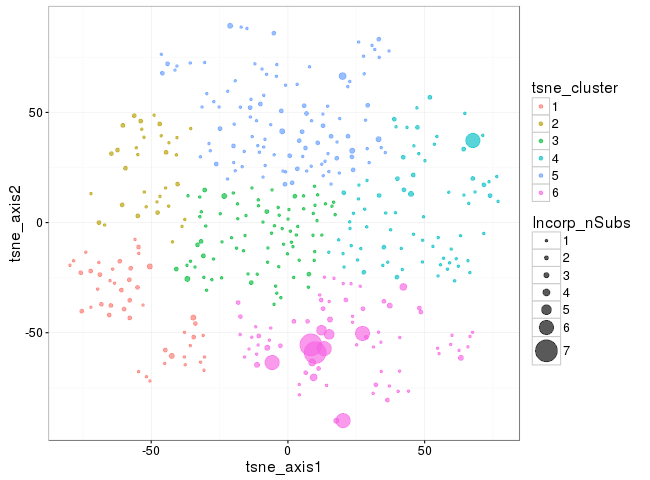

In [94]:
%%R -w 650

ggplot(df.l2fc.nSub, aes(tsne_axis1, tsne_axis2, color=tsne_cluster, size=Incorp_nSubs)) +
    geom_point(alpha=0.65) +
    scale_size(range=c(1, 10), trans='exp') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Plotting by phylum

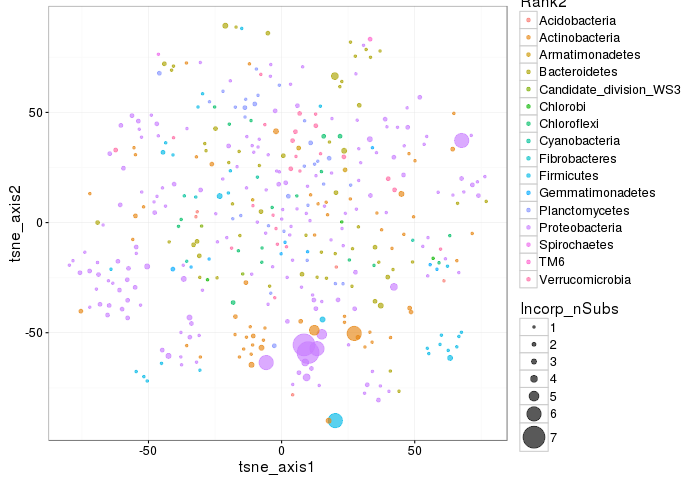

In [95]:
%%R -w 700

ggplot(df.l2fc.nSub, aes(tsne_axis1, tsne_axis2, color=Rank2, size=Incorp_nSubs)) +
    geom_point(alpha=0.65) +
    scale_size(range=c(1, 10), trans='exp') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Just plotting proteos

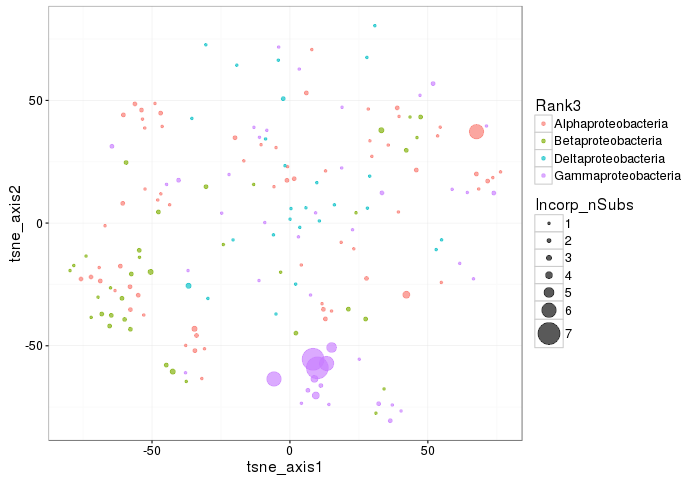

In [98]:
%%R -w 700

df.l2fc.nSub.proteo = df.l2fc.nSub %>%
    filter(Rank2 == 'Proteobacteria')

ggplot(df.l2fc.nSub.proteo, aes(tsne_axis1, tsne_axis2, color=Rank3, size=Incorp_nSubs)) +
    geom_point(alpha=0.65) +
    scale_size(range=c(1, 10), trans='exp') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Plotting which substrates incorporated

In [99]:
%%R
# incorporator of a particular substrate
df.l2fc.aSub = df.l2fc %>% 
    filter(OTU %in% df.inc$OTU) %>%
    group_by(OTU, Substrate) %>%
    mutate(Incorp_for_sub = any(Incorporator) %>% as.numeric) %>%
    distinct(OTU, Substrate) %>%
    dplyr::select(-Day, -Microcosm_replicate, -log2FoldChange, -p, -padj, -Incorporator) 

df.l2fc.aSub = inner_join(df.l2fc.aSub %>% filter(Incorp_for_sub == 1), 
                          df.tsne.res, c('OTU' = 'OTU'))

df.l2fc.aSub %>% nrow %>% print
df.l2fc.aSub %>% head(n=3) %>% as.data.frame

[1] 609
  Substrate sparsity_threshold       OTU    Rank1          Rank2
1   13C-Ami               0.25 OTU.10705 Bacteria     Firmicutes
2   13C-Ami               0.25 OTU.12810 Bacteria     Firmicutes
3   13C-Ami               0.25   OTU.914 Bacteria Actinobacteria
                Rank3           Rank4          Rank5             Rank6
1             Bacilli      Bacillales    Bacillaceae          Bacillus
2             Bacilli      Bacillales Planococcaceae Paenisporosarcina
3 Propionibacteriales Nocardioidaceae  Aeromicrobium              <NA>
         Rank7 Rank8 Incorp_for_sub tsne_axis1 tsne_axis2 tsne_cluster
1         <NA>  <NA>              1   63.27363  -61.41559            6
2 Sporosarcina  <NA>              1   20.18275  -89.85540            6
3         <NA>  <NA>              1  -13.41436  -27.22145            3


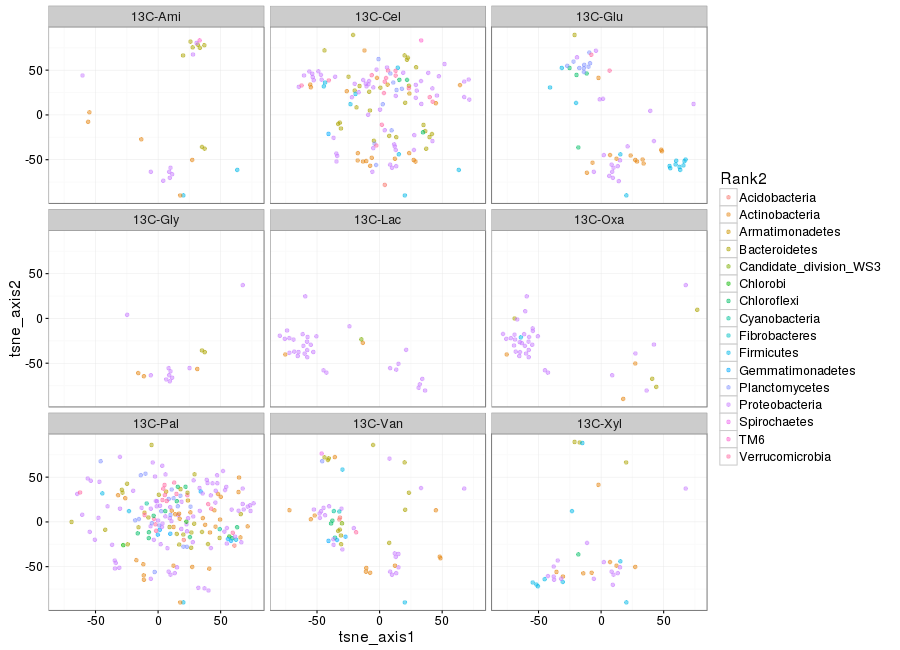

In [100]:
%%R -w 900 -h 650

ggplot(df.l2fc.aSub, aes(tsne_axis1, tsne_axis2, color=Rank2)) +
    geom_point(alpha=0.5) +
    facet_wrap(~ Substrate) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Plotting with t-sne clusters

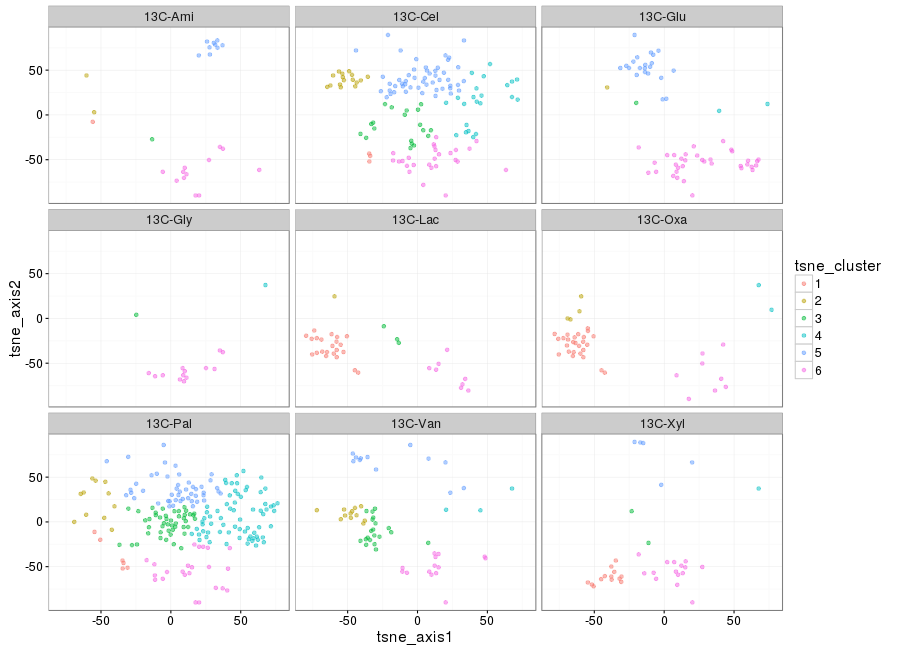

In [101]:
%%R -w 900 -h 650

ggplot(df.l2fc.aSub, aes(tsne_axis1, tsne_axis2, color=tsne_cluster)) +
    geom_point(alpha=0.5) +
    facet_wrap(~ Substrate) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## Plotting by day

In [128]:
%%R
# incorporator of a particular substrate
df.l2fc.aDay = df.l2fc %>% 
    filter(OTU %in% df.inc$OTU) %>%
    group_by(OTU, Day) %>%
    mutate(Incorp_for_sub = any(Incorporator) %>% as.numeric) %>%
    distinct(OTU, Day) %>%
    dplyr::select(-Substrate, -Microcosm_replicate, -log2FoldChange, -p, -padj, -Incorporator) 

df.l2fc.aDay = inner_join(df.l2fc.aDay %>% filter(Incorp_for_sub == 1), 
                          df.tsne.res, c('OTU' = 'OTU'))

df.l2fc.aDay %>% nrow %>% print
df.l2fc.aDay %>% head(n=3) %>% as.data.frame

[1] 606
  Day sparsity_threshold     OTU    Rank1          Rank2               Rank3
1   1               0.25 OTU.914 Bacteria Actinobacteria Propionibacteriales
2   1               0.25  OTU.31 Bacteria Actinobacteria   Corynebacteriales
3   1               0.25  OTU.23 Bacteria Actinobacteria   Corynebacteriales
            Rank4         Rank5 Rank6 Rank7 Rank8 Incorp_for_sub tsne_axis1
1 Nocardioidaceae Aeromicrobium  <NA>  <NA>  <NA>              1  -13.41436
2    Nocardiaceae   Rhodococcus  <NA>  <NA>  <NA>              1   48.62253
3    Nocardiaceae   Rhodococcus  <NA>  <NA>  <NA>              1   48.07541
  tsne_axis2 tsne_cluster
1  -27.22145            3
2  -40.56937            6
3  -38.78594            6


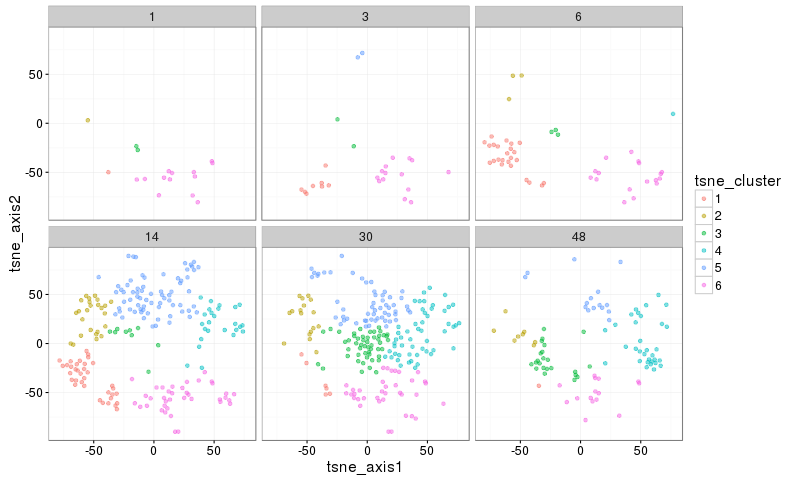

In [130]:
%%R -w 800
# just by day
ggplot(df.l2fc.aDay, aes(tsne_axis1, tsne_axis2, color=tsne_cluster)) +
    geom_point(alpha=0.5) +
    facet_wrap( ~ Day) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## Plotting by substrate &  time

* late vs early incoporators


In [124]:
%%R

# just incorporators
df.l2fc.inc = df.l2fc %>% 
    filter(Incorporator == 1) 
df.l2fc.inc = inner_join(df.l2fc.inc, 
                         df.tsne.res, c('OTU' = 'OTU'))

df.l2fc.inc %>% nrow %>% print
df.l2fc.inc %>% arrange(OTU) %>% head(n=3) %>% as.data.frame

[1] 753
  Substrate Day Microcosm_replicate sparsity_threshold       OTU log2FoldChange
1   13C-Xyl   3                   2               0.25     OTU.1       1.955240
2   13C-Xyl  14                   1               0.25     OTU.1       2.240263
3   13C-Cel  14                   1               0.25 OTU.10019       3.905980
             p        padj    Rank1          Rank2               Rank3
1 4.737103e-05 0.008256770 Bacteria Proteobacteria Gammaproteobacteria
2 1.945191e-04 0.032139862 Bacteria Proteobacteria Gammaproteobacteria
3 1.188917e-06 0.000119852 Bacteria Proteobacteria Alphaproteobacteria
            Rank4             Rank5       Rank6 Rank7 Rank8 Incorporator
1 Pseudomonadales  Pseudomonadaceae Pseudomonas  <NA>  <NA>            1
2 Pseudomonadales  Pseudomonadaceae Pseudomonas  <NA>  <NA>            1
3     Rhizobiales Hyphomicrobiaceae     Devosia  <NA>  <NA>            1
  tsne_axis1 tsne_axis2 tsne_cluster
1  -37.85124  -60.95639            1
2  -37.85124  -60.9563

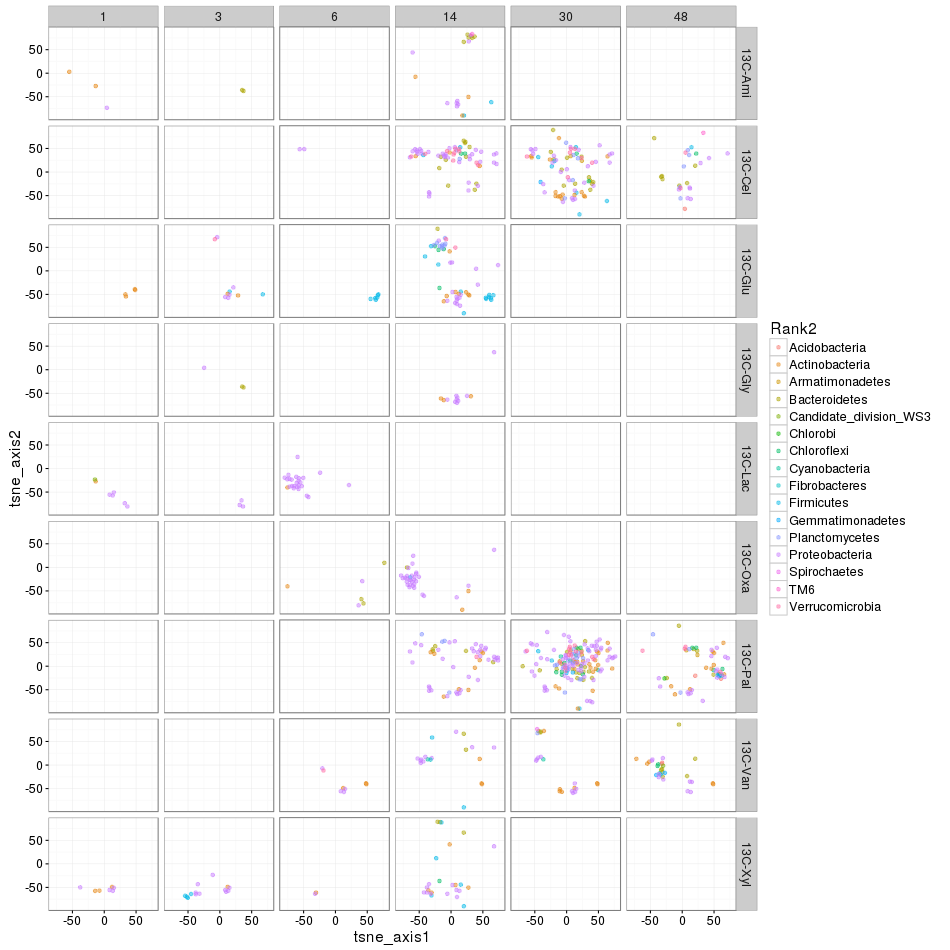

In [127]:
%%R -w 950 -h 950

# coloring by phylum
ggplot(df.l2fc.inc, aes(tsne_axis1, tsne_axis2, color=Rank2)) +
    geom_point(alpha=0.5) +
    facet_grid(Substrate ~ Day) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

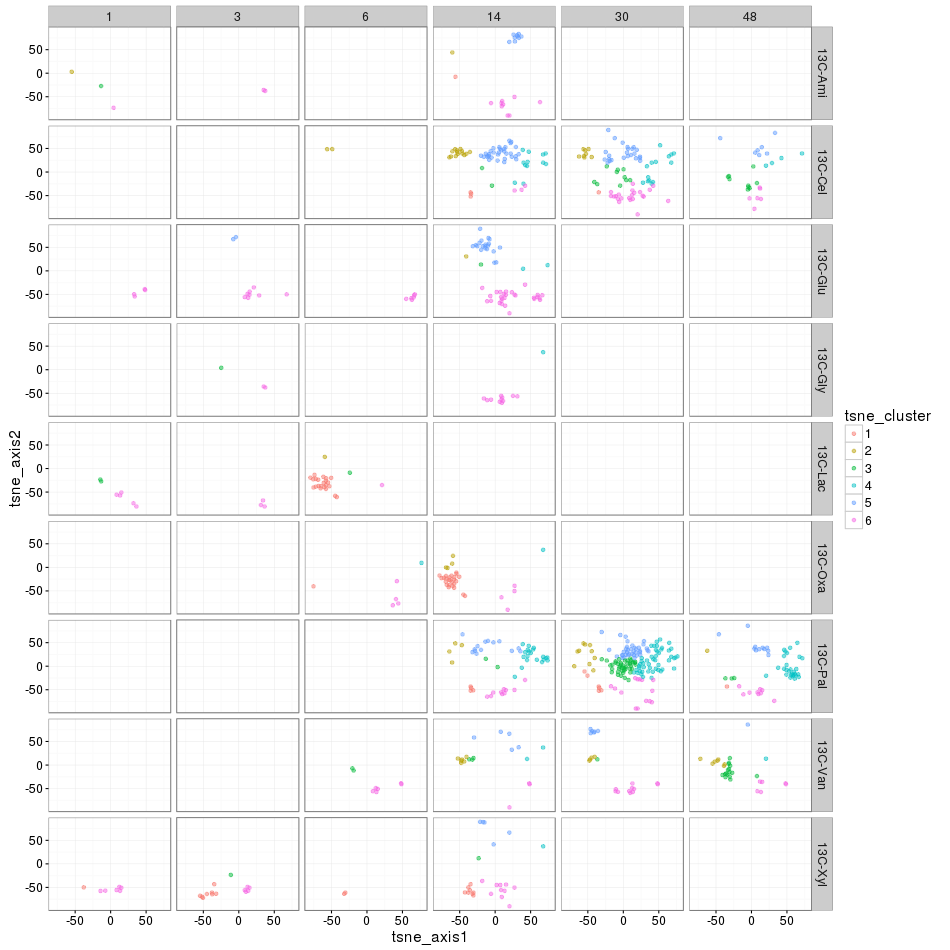

In [132]:
%%R -w 950 -h 950

# color by tsne cluster
ggplot(df.l2fc.inc, aes(tsne_axis1, tsne_axis2, color=tsne_cluster)) +
    geom_point(alpha=0.5) +
    facet_grid(Substrate ~ Day) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Suming number of incorporators in each t-SNE cluster for each treatment/day

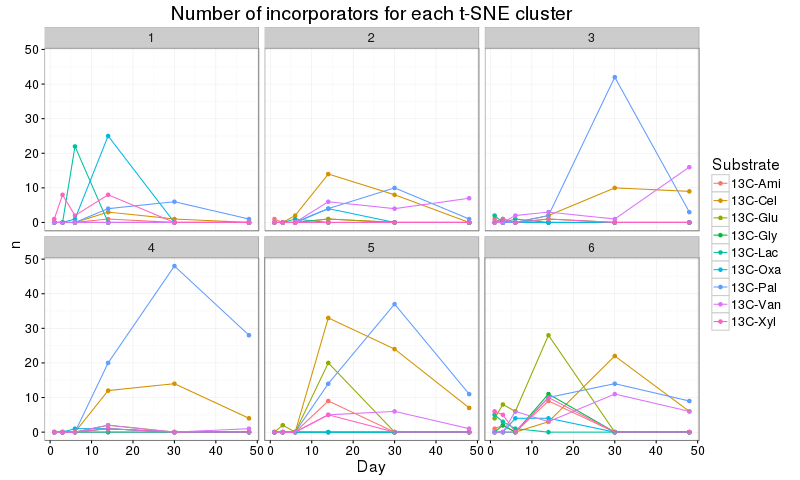

In [134]:
%%R -w 800

df.l2fc.inc.sum = df.l2fc.inc %>%
    group_by(Substrate, Day, tsne_cluster) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    complete(Substrate, Day, tsne_cluster) %>%
    mutate(n = ifelse(is.na(n), 0, n))

ggplot(df.l2fc.inc.sum, aes(Day, n, color=Substrate)) +
    geom_point() +
    geom_line() +
    labs(title='Number of incorporators for each t-SNE cluster') +
    facet_wrap(~ tsne_cluster) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Plotting l2fc by t-SNE cluster

In [158]:
%%R
# incorporators of any substrate
df.l2fc.aInc = df.l2fc %>% 
    group_by(OTU) %>%
    filter(any(Incorporator)) %>%
    ungroup()

df.l2fc.aInc = inner_join(df.l2fc.aInc, 
                          df.tsne.res, c('OTU' = 'OTU'))

df.l2fc.aInc %>% nrow %>% print
df.l2fc.aInc %>% head(n=3) %>% as.data.frame

[1] 9469
  Substrate Day Microcosm_replicate sparsity_threshold      OTU log2FoldChange
1   13C-Ami   1                   2               0.25 OTU.1833      0.1993560
2   13C-Ami   1                   2               0.25  OTU.201      0.5906930
3   13C-Ami   1                   2               0.25 OTU.3759     -0.5006813
          p padj    Rank1         Rank2            Rank3                Rank4
1 0.9484486    1 Bacteria Acidobacteria            DA023 uncultured_bacterium
2 0.7410492    1 Bacteria Bacteroidetes Sphingobacteriia   Sphingobacteriales
3 0.9911364    1 Bacteria Bacteroidetes Sphingobacteriia   Sphingobacteriales
             Rank5           Rank6                Rank7 Rank8 Incorporator
1             <NA>            <NA>                 <NA>  <NA>            0
2 Chitinophagaceae      uncultured uncultured_bacterium  <NA>            0
3 Chitinophagaceae Ferruginibacter uncultured_bacterium  <NA>            0
  tsne_axis1 tsne_axis2 tsne_cluster
1  60.975161 -26.411920   

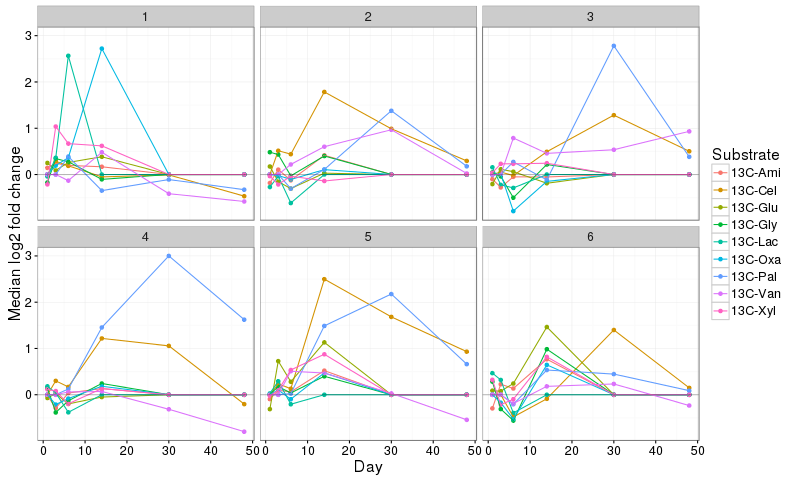

In [162]:
%%R -w 800
df.l2fc.aInc.sum = df.l2fc.aInc %>%
    group_by(Substrate, Day, tsne_cluster) %>%
    summarize(median_l2fc = median(log2FoldChange)) %>%
    ungroup() %>%
    complete(Substrate, Day, tsne_cluster) %>%
    mutate(median_l2fc = ifelse(is.na(median_l2fc), 0, median_l2fc))

ggplot(df.l2fc.aInc.sum, aes(Day, median_l2fc, color=Substrate)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept=0, alpha=0.25) +
    labs(y='Median log2 fold change') +
    facet_wrap(~ tsne_cluster) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Taxonomic composition of functional groups

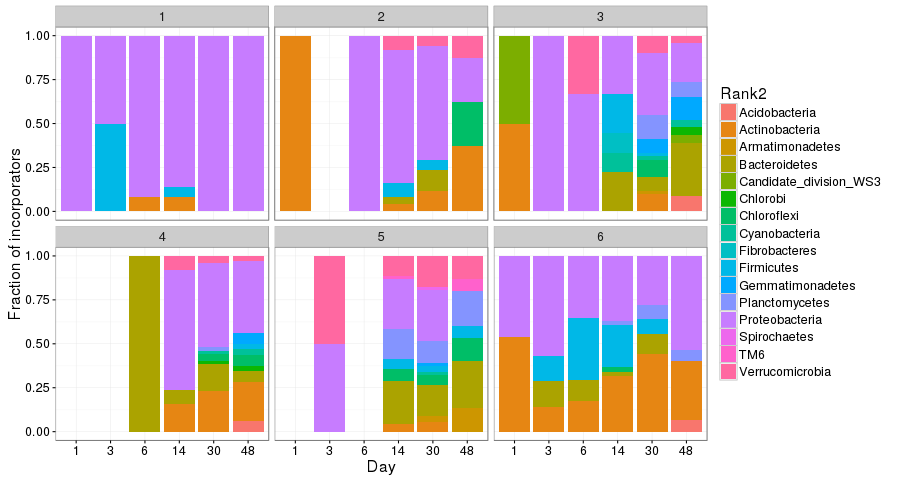

In [138]:
%%R -w 900
# taxonomy of the functional groups
df.l2fc.inc.sum = df.l2fc.inc %>%
    distinct(OTU, Day) %>%
    group_by(Day, tsne_cluster, Rank2) %>%
    summarize(n = n()) 

df.l2fc.inc.sum$Day = reorder(df.l2fc.inc.sum$Day %>% as.character, df.l2fc.inc.sum$Day)

ggplot(df.l2fc.inc.sum, aes(Day, n, fill=Rank2)) +
    geom_bar(stat='identity', position='fill') +
    labs(y='Fraction of incorporators') +
    facet_wrap(~ tsne_cluster) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

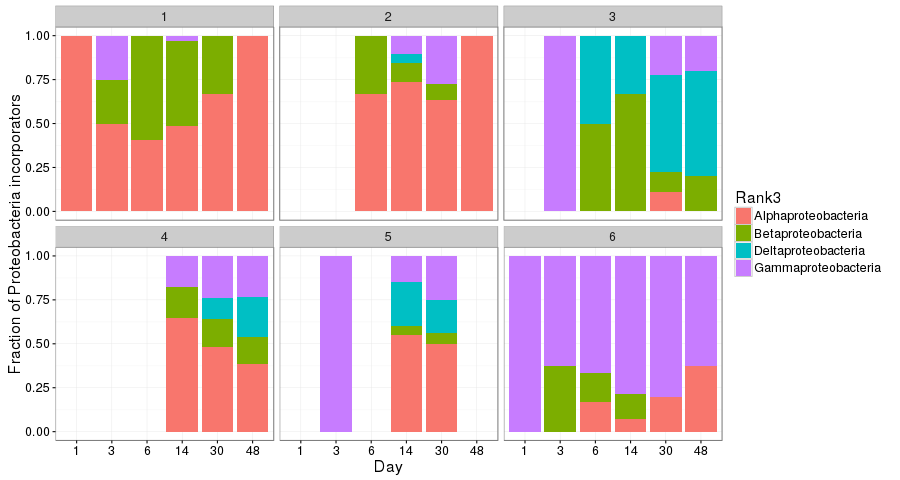

In [139]:
%%R -w 900
# taxonomy of the functional groups
df.l2fc.inc.sum = df.l2fc.inc %>%
    distinct(OTU, Day) %>%
    filter(Rank2 == 'Proteobacteria') %>%
    group_by(Day, tsne_cluster, Rank3) %>%
    summarize(n = n()) 

df.l2fc.inc.sum$Day = reorder(df.l2fc.inc.sum$Day %>% as.character, df.l2fc.inc.sum$Day)

ggplot(df.l2fc.inc.sum, aes(Day, n, fill=Rank3)) +
    geom_bar(stat='identity', position='fill') +
    labs(y='Fraction of Proteobacteria incorporators') +
    facet_wrap(~ tsne_cluster) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# SOM

* using self organizing map + t-SNE to ID functional groups

In [57]:
%%R
mtx.train = as.matrix(scale(df.l2fc.w))
mtx.train %>% head(n=3)

           13C-Ami_1 13C-Ami_14   13C-Ami_3   13C-Ami_6 13C-Cel_14  13C-Cel_3
OTU.1     0.06491204 -0.1581769 -0.68259045 -1.45366314  -0.924726 -0.5880530
OTU.10019 1.03597771 -0.6324124  0.35515430 -2.24860295   1.993891  1.2567261
OTU.1002  0.09286178 -1.5344460 -0.04175296 -0.03587464  -0.547531 -0.1861181
          13C-Cel_30  13C-Cel_48   13C-Cel_6   13C-Glu_1   13C-Glu_14
OTU.1     -0.5671924  0.08718702 -0.65973305  1.83536139  0.004110054
OTU.10019  0.3945146 -0.21591020  0.86888755  0.09125521 -1.069558866
OTU.1002   1.1831929 -0.25318826  0.03435466 -0.12974443 -1.334660373
           13C-Glu_3   13C-Glu_6  13C-Gly_1  13C-Gly_14   13C-Gly_3   13C-Gly_6
OTU.1      0.1659269 -0.10267176  1.5300918  0.16670234 -1.00706979 -0.47976387
OTU.10019 -0.1219280 -1.36034855  0.8071875  1.01213812  1.32042438 -0.09484299
OTU.1002  -0.1219280 -0.08129824 -0.1648830 -0.06893713  0.04147494  0.13942620
           13C-Lac_1  13C-Lac_3   13C-Lac_6 13C-Oxa_14  13C-Oxa_3   13C-Oxa_6
OTU.1     

In [58]:
%%R
# assuming ~X groupings
n.expect = 40
dim.size = floor(sqrt(n.expect * 10))
som_grid = somgrid(xdim=dim.size, ydim=dim.size, top='hexagonal')
som_model = som(mtx.train,
                grid = som_grid,
                n.hood='circular')


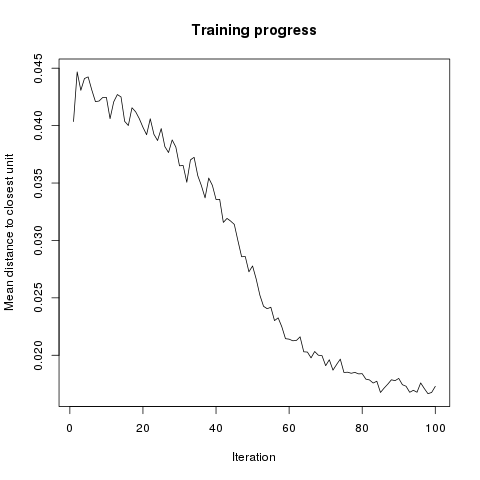

In [59]:
%%R
plot(som_model, type="changes")

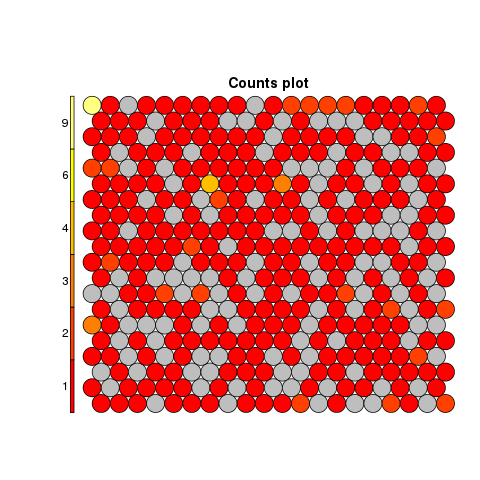

In [60]:
%%R
plot(som_model, type="count")

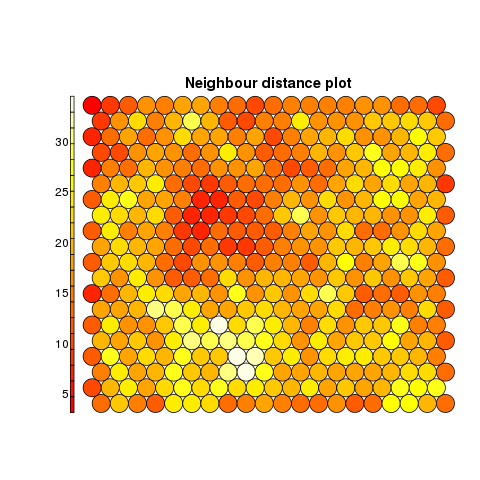

In [61]:
%%R
plot(som_model, type="dist.neighbours")

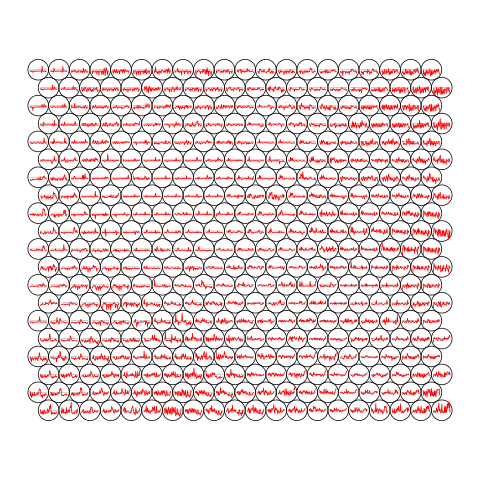

In [62]:
%%R
plot(som_model, type="codes")

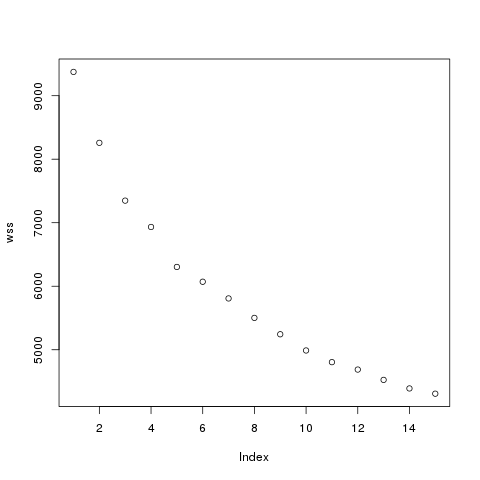

In [63]:
%%R
mydata = som_model$codes 
wss = (nrow(mydata)-1)*sum(apply(mydata,2,var)) 
for (i in 2:15) {
  wss[i] = sum(kmeans(mydata, centers=i)$withinss)
}
plot(wss)

In [64]:
%%R
## use hierarchical clustering to cluster the codebook vectors
n.clusts = 6
som_cluster <- cutree(hclust(dist(som_model$codes)), n.clusts)
som_cluster %>% head

[1] 1 1 1 1 1 1


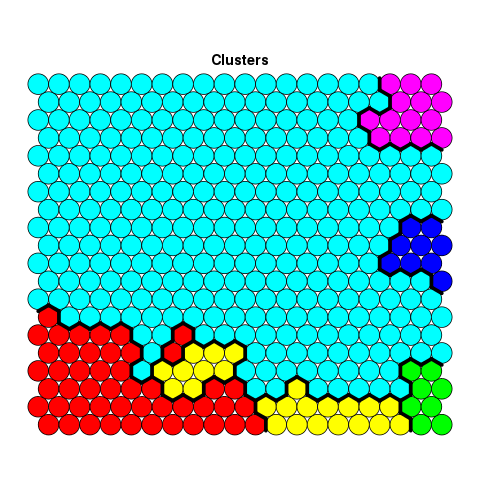

In [65]:
%%R
cols = rainbow(n.clusts)

# plot these results:
plot(som_model, type="mapping", bgcol = cols[som_cluster], main = "Clusters") 
add.cluster.boundaries(som_model, som_cluster)

In [66]:
%%R
# mapping of data to grid nodes
df.l2fc.w.som = df.l2fc.w
df.l2fc.w.som$som_cluster = som_cluster[som_model$unit.classif]
df.l2fc.w.som$OTU = rownames(df.l2fc.w.som)
df.l2fc.w.som %>% head(n=3)

            13C-Ami_1 13C-Ami_14  13C-Ami_3  13C-Ami_6  13C-Cel_14  13C-Cel_3
OTU.1     -0.01820865  0.1739515 -0.3314178 -0.6235129 -0.54059364 -0.2302009
OTU.10019  0.61441986 -0.2550232  0.2052660 -0.9731104  3.90597961  0.8263626
OTU.1002   0.00000000 -1.0709669  0.0000000  0.0000000  0.03407083  0.0000000
          13C-Cel_30 13C-Cel_48  13C-Cel_6 13C-Glu_1 13C-Glu_14 13C-Glu_3
OTU.1      0.1457742  0.3395559 -0.4822453 1.2098681  0.5253327 0.2585179
OTU.10019  1.6166713 -0.1469741  0.5798252 0.1360641 -1.0149975 0.0000000
OTU.1002   2.8229272 -0.2068126  0.0000000 0.0000000 -1.3953232 0.0000000
            13C-Glu_6 13C-Gly_1 13C-Gly_14  13C-Gly_3  13C-Gly_6 13C-Lac_1
OTU.1     -0.01600647 0.8641228  0.4527054 -0.8361779 -0.4264192 0.9301583
OTU.10019 -0.95787122 0.4955757  1.1851210  1.0199176 -0.1613348 0.1663213
OTU.1002   0.00000000 0.0000000  0.2485669  0.0000000  0.0000000 0.0000000
           13C-Lac_3  13C-Lac_6   13C-Oxa_14  13C-Oxa_3   13C-Oxa_6 13C-Pal_14
OTU.1     -0.

### Appending tsne values to metadata

In [67]:
%%R
# incorporator of a particular substrate
df.l2fc.aSub = df.l2fc %>% 
    filter(OTU %in% df.inc$OTU) %>%
    group_by(OTU, Substrate) %>%
    mutate(Incorp_for_sub = any(Incorporator) %>% as.numeric) %>%
    distinct(OTU, Substrate) %>%
    dplyr::select(-Day, -Microcosm_replicate, -log2FoldChange, -p, -padj, -Incorporator) 

df.l2fc.aSub = inner_join(df.l2fc.aSub %>% filter(Incorp_for_sub == 1), 
                          df.tsne.res, c('OTU' = 'OTU'))

# joining with SOM clusters
df.l2fc.aSub = inner_join(df.l2fc.aSub, 
                          df.l2fc.w.som %>% 
                              dplyr::select(OTU, som_cluster) %>%
                              mutate(som_cluster = som_cluster %>% as.character), 
                          c('OTU' = 'OTU'))

# writing
df.l2fc.aSub %>% nrow %>% print
df.l2fc.aSub %>% head(n=3) %>% as.data.frame

[1] 609
  Substrate sparsity_threshold       OTU    Rank1            Rank2
1   13C-Ami               0.25 OTU.10705 Bacteria     __Firmicutes
2   13C-Ami               0.25 OTU.12810 Bacteria     __Firmicutes
3   13C-Ami               0.25   OTU.914 Bacteria __Actinobacteria
                  Rank3             Rank4            Rank5               Rank6
1             __Bacilli      __Bacillales    __Bacillaceae          __Bacillus
2             __Bacilli      __Bacillales __Planococcaceae __Paenisporosarcina
3 __Propionibacteriales __Nocardioidaceae  __Aeromicrobium                <NA>
           Rank7 Rank8 Incorp_for_sub tsne_axis1 tsne_axis2 tsne_cluster
1           <NA>  <NA>              1   63.27363  -61.41559            6
2 __Sporosarcina  <NA>              1   20.18275  -89.85540            6
3           <NA>  <NA>              1  -13.41436  -27.22145            3
  som_cluster
1           5
2           5
3           2


### Plotting t-SNE with SOM cluster colors

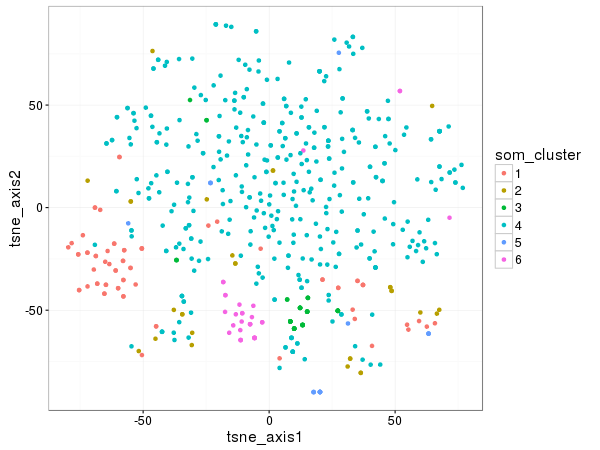

In [69]:
%%R -w 600 -h 450

ggplot(df.l2fc.aSub, aes(tsne_axis1, tsne_axis2, color=som_cluster)) +
    geom_point() +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### faceting by substrate(s) incorporated

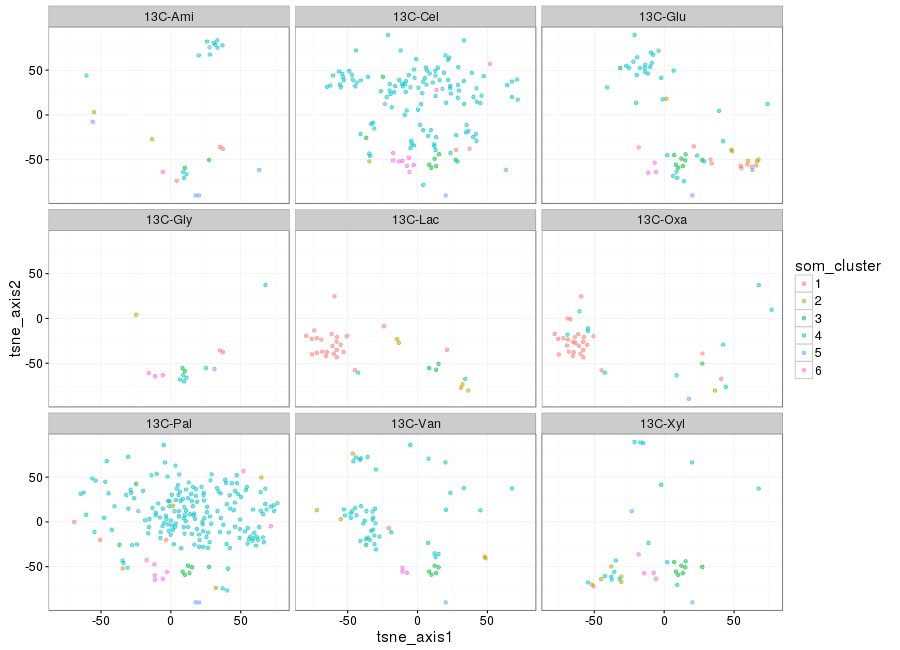

In [70]:
%%R -w 900 -h 650

ggplot(df.l2fc.aSub, aes(tsne_axis1, tsne_axis2, color=som_cluster)) +
    geom_point(alpha=0.5) +
    facet_wrap(~ Substrate) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

***
***

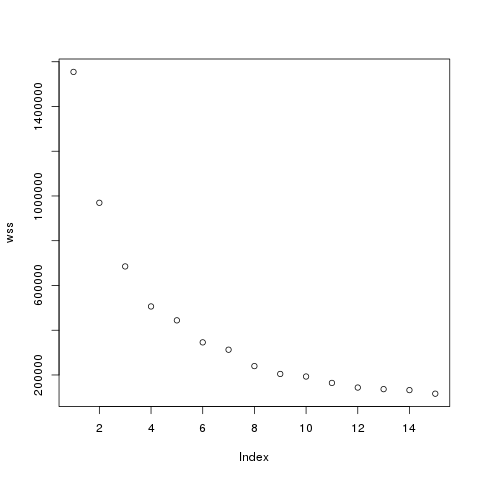

In [480]:
%%R
# kmeans
mydata = tsne.res 
wss = (nrow(mydata)-1)*sum(apply(mydata,2,var)) 
for (i in 2:15) {
  wss[i] = sum(kmeans(mydata, centers=i)$withinss)
}
plot(wss)

In [481]:
%%R
## use hierarchical clustering to cluster the codebook vectors
n.clusts = 5

df.tsne.res$cluster = cutree(hclust(dist(tsne.res)), n.clusts) %>% as.vector 
 
df.tsne.res %>% head

   tsne_axis1  tsne_axis2       OTU tsne_cluster cluster
1  77.2273276  23.0997531     OTU.1            1       1
2 -65.5364886 -35.0744735 OTU.10019            2       2
3  28.7523752   0.6615463  OTU.1002            3       2
4 -32.4726129 -43.1442797  OTU.1004            2       2
5  -3.8359784  43.8216549  OTU.1008            4       3
6  -0.8173781 -14.2530781  OTU.1016            3       2


***
***

# SOM Sandbox

In [181]:
%%R
library(kohonen)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: class

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: MASS

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘MASS’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:dplyr’:

    select


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [211]:
%%R
data_train = iris[,c(1,2,3,4)]
data_train_matrix = as.matrix(scale(data_train))
data_train_matrix %>% head

     Sepal.Length Sepal.Width Petal.Length Petal.Width
[1,]   -0.8976739  1.01560199    -1.335752   -1.311052
[2,]   -1.1392005 -0.13153881    -1.335752   -1.311052
[3,]   -1.3807271  0.32731751    -1.392399   -1.311052
[4,]   -1.5014904  0.09788935    -1.279104   -1.311052
[5,]   -1.0184372  1.24503015    -1.335752   -1.311052
[6,]   -0.5353840  1.93331463    -1.165809   -1.048667


In [212]:
%%R
# grid size?
floor(sqrt(iris %>% nrow))

[1] 12


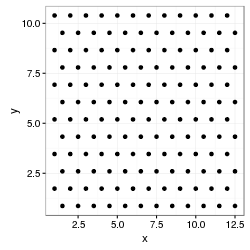

In [213]:
%%R -w 250 -h 250
som_grid = somgrid(xdim=12, ydim=12, topo='hexagonal')

ggplot(som_grid$pts %>% as.data.frame, aes(x, y)) +
    geom_point() +
    theme_bw()

In [214]:
%%R
som_model = som(data_train_matrix,
               grid=som_grid,
               rlen=100,
               alpha=c(0.05,0.01),
               keep.data=TRUE,
               n.hood='circular')
som_model

som map of size 12x12 with a hexagonal topology.
Training data included.


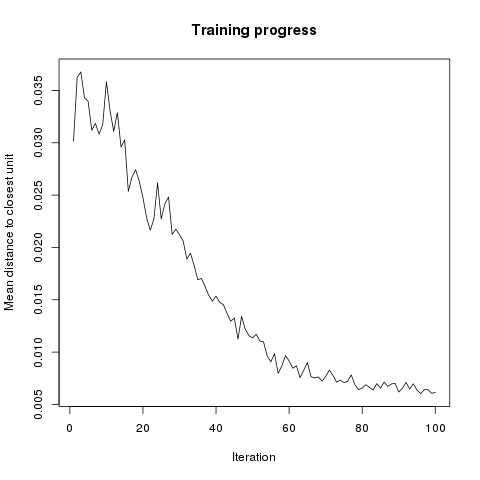

In [215]:
%%R
plot(som_model, type='changes')

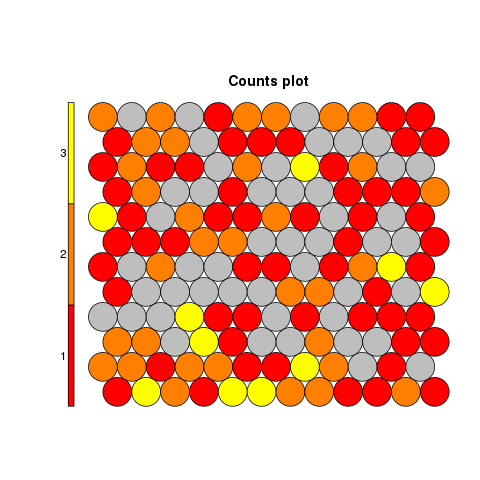

In [216]:
%%R
plot(som_model, type='count')

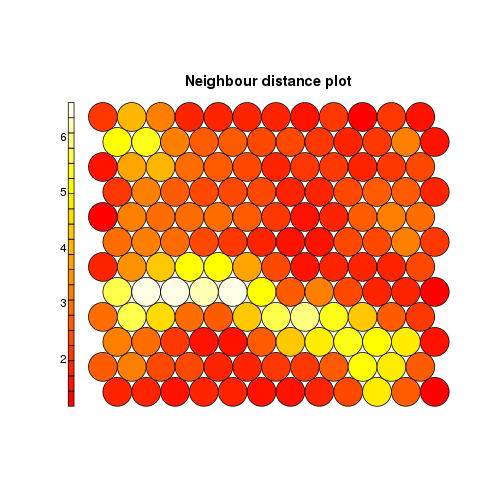

In [217]:
%%R
plot(som_model, type="dist.neighbours")

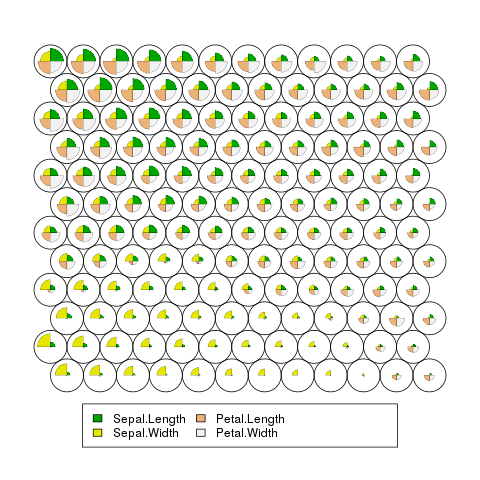

In [218]:
%%R
plot(som_model, type="codes")

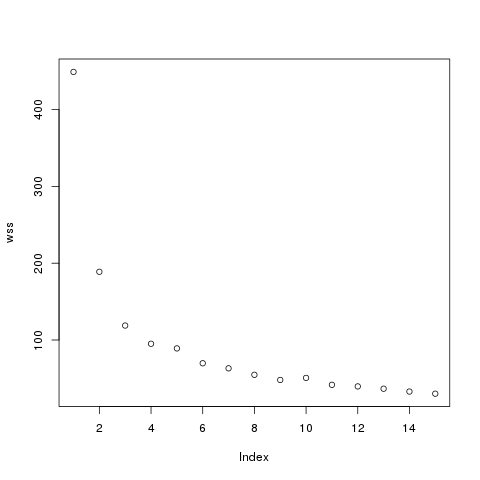

In [219]:
%%R
mydata <- som_model$codes 
wss <- (nrow(mydata)-1)*sum(apply(mydata,2,var)) 
for (i in 2:15) {
  wss[i] <- sum(kmeans(mydata, centers=i)$withinss)
}
plot(wss)

In [238]:
%%R
## use hierarchical clustering to cluster the codebook vectors
n.clusts = 4
som_cluster <- cutree(hclust(dist(som_model$codes)), n.clusts)
som_cluster %>% head

[1] 1 1 1 1 1 2


In [255]:
%%R
# mapping of data to grid nodes
som_model$unit.classif

  [1]  28  32   6   7   3  14   5  17   9  20  26   5  21   8  25  13  14  28
 [19]  25   2  40  15   4  42   5  32  29  28  41   6  20  40   1  13  20  19
 [37]  40   3   8  17  16  10   7  16   2  21   2   6  26  18  88  63  88  36
 [55]  90  70  63  11  77  46  12  67  84  91  44  76  56  71 108  60  61  81
 [73] 107  94  77  76  89 101  92  72  60  60  71 118  56  49  75  96  55  48
 [91]  47  91  71  11  58  55  69  66  23  70  85 142 137 127 138 122  35 123
[109] 132 121  74 131 125 143 141  85 114 133 135 108 110 141 135 118  86 111
[127] 117 116 139 112 123 133 139 105 106 122  85 114 116  98  97  98 142 110
[145] 109 138 144 126  73 116


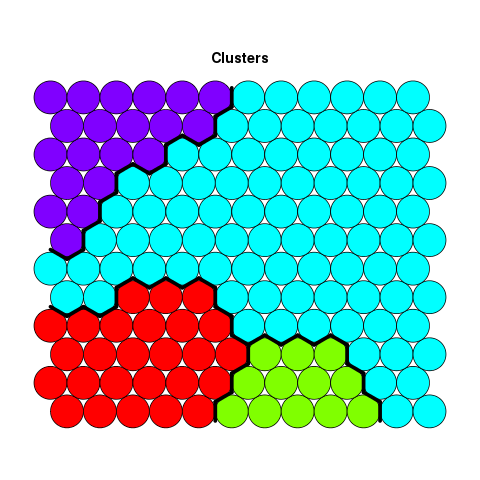

In [239]:
%%R
cols = rainbow(n.clusts)

# plot these results:
plot(som_model, type="mapping", bgcol = cols[som_cluster], main = "Clusters") 
add.cluster.boundaries(som_model, som_cluster)